In [90]:
import cv2
import numpy as np
import cv2
import glob
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt



Generalized Hough Transform , Deniz Arda Dulkadir , 2220765014 

Find a template in a image with Hough Transform

Generalized Hough Tranform get gradient and vector values of a template using center and edge map.

After that transform the image into a Hough space to use the values and get votes for edge points than using the most votes find the template in the image.

In [91]:
fish_dir = 'dataset_fish'
flower_dir = 'dataset_daisy'

In [92]:
def get_edge_points(template,divide):
    count=0
    edge_points=[]
    for y in range(len(template)):
        for x in range(len(template[0])):
            if template[y][x]==255:
                if count == divide:
                    edge_points.append([x,y])  
                    count=0
                else:
                    count+=1
    return edge_points
#Given a edge map template returns points of the template/divide number of points

In [93]:
def create_accumulator_basic(x,y):
    A=[]
    for yt in range(y):
        temp=[]
        for xt in range(x):
            temp.append(0)
        A.append(temp)
    return A

In [94]:
def create_accumulator(x,y,s,alpha):
    A=[]
    for yt in range(y):
        tempy=[]
        for xt in range(x):
            tempx=[]
            for st in range(len(s)):
                temps=[]
                for alphat in range(len(alpha)):
                    temps.append(0)
                tempx.append(temps)
            tempy.append(tempx)
        A.append(tempy)
    return A
# Creates the accumulator with all the possible values

In [95]:
def find_center(points):
    tx=0
    ty=0
    for point in points:
        tx+=point[0]
        ty+=point[1]
    return tx/len(points),ty/len(points)
# Finds center of given points


In [96]:
def get_vector(p1,p2):
    return [p2[0]-p1[0],p2[1]-p1[1]]

In [97]:
def r_table(imagepath):
    imagepath=imagepath+("\\")+('template.png')
    print(imagepath)
    img = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
    template = cv2.Canny(img, 50, 100 )
    edge_points=get_edge_points(template,1)
    cx,cy=find_center(edge_points)
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)
    # Getting the edge points of the edge map and getting a gradient map

    edge_point_directions = defaultdict(list)
    for x,y in (edge_points):
            
        gradient_angle = angle[y, x]
        
        edge_orientation = gradient_angle - 90
        
        if edge_orientation < 0:
            edge_orientation += 360
        bins=72
        # Using bins for small float number chances

        int_orientation = int(edge_orientation/bins)
        rx,ry=get_vector((x,y),(cx,cy))
        # After getting vector and phi value add it to dict
        
        edge_point_directions[int_orientation].append((rx,ry))
    plt.subplot(1, 2, 2)
    plt.imshow(template,cmap='gray')
    plt.show()
    return edge_point_directions


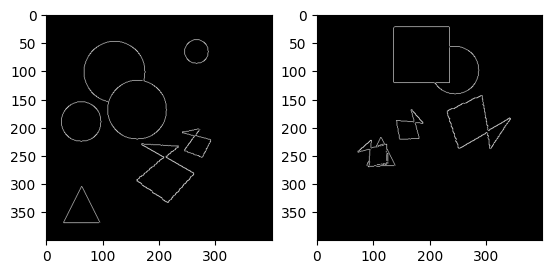

In [98]:
img_paths = [
    r'dataset_fish\scene_00.png',
    r'dataset_fish\scene_01.png'
]
for idx, p in enumerate(img_paths):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 50, 100)
    plt.subplot(1, len(img_paths), idx + 1)
    plt.imshow(edges, cmap='gray')
plt.show()

I used Canny and it worked well . I chaged treshold values and it gave good results.

In [99]:
def make_transform(image_dir,edge_point_directions):
    image_pattern = os.path.join(image_dir, '*.png') 
    image_files = glob.glob(image_pattern)
    # Using bins again for small changes
    bins=72
    for file_path in image_files:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        filename = os.path.basename(file_path)
        edges = cv2.Canny(img, 100, 200)
        edge_points = get_edge_points(edges, 1) 
        # Getting the edge map the image 

        scales = [1, 1.5, 2, 3]
        rotations = [i for i in range(0, 360, 15)]
        accumulator = np.zeros((500, 500, len(scales), len(rotations)), dtype=int)
        # Building the accumlator map 4d array with x y rotations and scales

        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)
        # Getting the gradient map of the image

        for s_idx, s_val in enumerate(scales):
            for r_idx, r_val in enumerate(rotations):
                r_rad = math.radians(r_val)
                for x, y in edge_points:
                    # Checknig every edge point points rotation and scale in this loop

                    gradient_angle = angle[y, x]
                    
                    edge_orientation = gradient_angle - 90
                    unrotated_orientation = edge_orientation - r_val
                    if unrotated_orientation < 0:
                        unrotated_orientation += 360
                    int_orientation = int(unrotated_orientation/bins)
                    # After getting the gradient value of the currnet point and rotation
                    # Get the values from the phi table

                    temp_points = edge_point_directions.get(int_orientation, [])

                    for rx, ry in temp_points:
                        # Geting the accumulator point for the current place
                        a = int( (x + s_val * (rx * math.cos(r_rad) - ry * math.sin(r_rad)))  )
                        b = int( (y + s_val * (rx * math.sin(r_rad) + ry * math.cos(r_rad)))  )

                        if 0 <= a < 500 and 0 <= b < 500: 
                            accumulator[b][a][s_idx][r_idx] += 1
                        # add a vote the the accumulator
        
        
        peak_indices = np.unravel_index(np.argmax(accumulator), accumulator.shape)
        y_center, x_center, s_idx, r_idx = peak_indices
        max_vote=accumulator[y_center][x_center][s_idx][r_idx]
        # Get the maximum vote point
        detections = []
        acc_copy = np.copy(accumulator)
        heatmap = accumulator.max(axis=(2, 3))
        #Get the heatmap of the accumulator 
        
        num_peaks=4
        vote_threshold_ratio=0.6
        supp = 40
        # Hyperparamaters to test; num peaks is how many shapes to check,vote threshold is the 
        # current points vote compared to best and supp is suppressing value of the object

        best_vote = 0
        template_h, template_w = 100,100

        for i in range(num_peaks):
            peak_indices = np.unravel_index(np.argmax(acc_copy), acc_copy.shape)
            y, x, s_idx, r_idx = peak_indices
            
            max_vote = acc_copy[y, x, s_idx, r_idx]
            
            if i == 0:
                best_vote = max_vote
            # Best voted point
            
            if max_vote < (best_vote * vote_threshold_ratio):
                break
            # Early stop of points that have low treshold
            detections.append({
                "y": y, "x": x,
                "scale": scales[s_idx], 
                "rotation": rotations[r_idx],
                "votes": max_vote
            })
            # If all is ok than add 
            s_val = scales[s_idx]
            h_suppress = int(supp * s_val)
            w_suppress = int(supp * s_val)
            
            y_min = max(0, y - h_suppress // 2)
            y_max = min(400, y + h_suppress // 2)
            x_min = max(0, x - w_suppress // 2)
            x_max = min(400, x + w_suppress // 2)
            
            acc_copy[y_min:y_max, x_min:x_max, :, :] = 0
            # This part prevents the algo to find same object twice by making 0
            # around the object supp value can be changed

        scene_img_color = cv2.imread(file_path)
        print(f"--- Detections for {filename} ---")

        for i, det in enumerate(detections):
            xt, yt = det['x'], det['y']
            st, rt = det['scale'], det['rotation']
            print(f"Top {i+1}: (x={xt}, y={yt}), Scale: {st}x, Rot: {rt} deg")
            cv2.circle(scene_img_color, (xt, yt), 20, (0, 0, 255), 3) 
            # For all good points draw a circle

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Accumulator Heatmap')
        plt.colorbar(label='Max Vote Count')    

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(scene_img_color, cv2.COLOR_BGR2RGB))
        plt.title(f'Detections in {filename}')
        plt.show()



    print("Finished displaying all images.")

dataset_fish\template.png


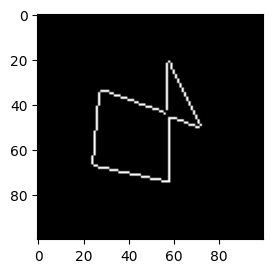

--- Detections for scene_00.png ---
Top 1: (x=205, y=278), Scale: 2x, Rot: 300 deg
Top 2: (x=264, y=228), Scale: 1x, Rot: 285 deg


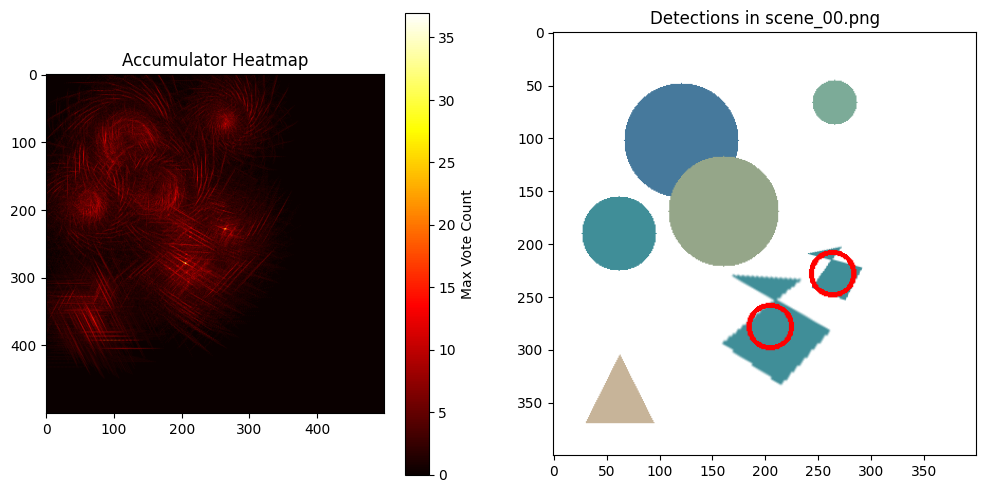

--- Detections for scene_01.png ---
Top 1: (x=161, y=198), Scale: 1x, Rot: 345 deg
Top 2: (x=280, y=190), Scale: 2x, Rot: 60 deg
Top 3: (x=101, y=248), Scale: 1x, Rot: 255 deg


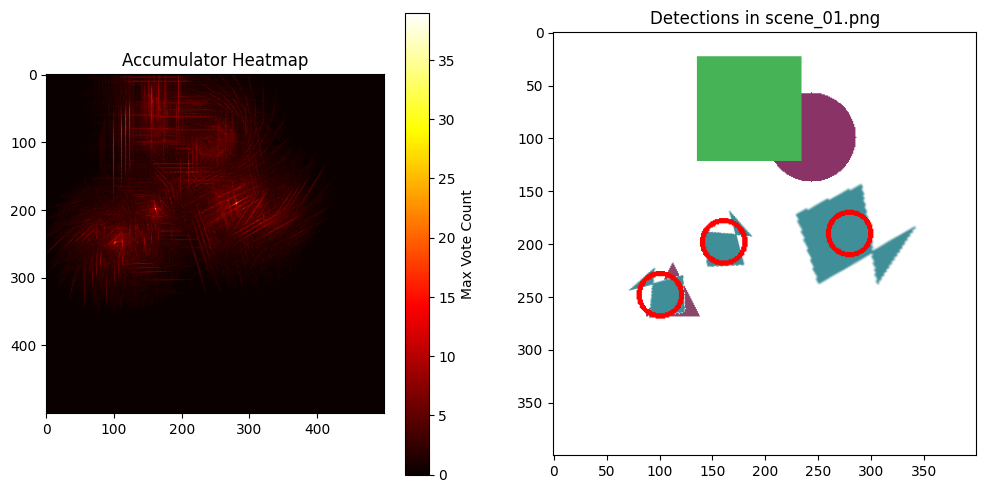

--- Detections for scene_02.png ---
Top 1: (x=200, y=264), Scale: 2x, Rot: 330 deg
Top 2: (x=237, y=98), Scale: 1.5x, Rot: 45 deg
Top 3: (x=279, y=199), Scale: 2x, Rot: 270 deg
Top 4: (x=240, y=270), Scale: 1x, Rot: 135 deg


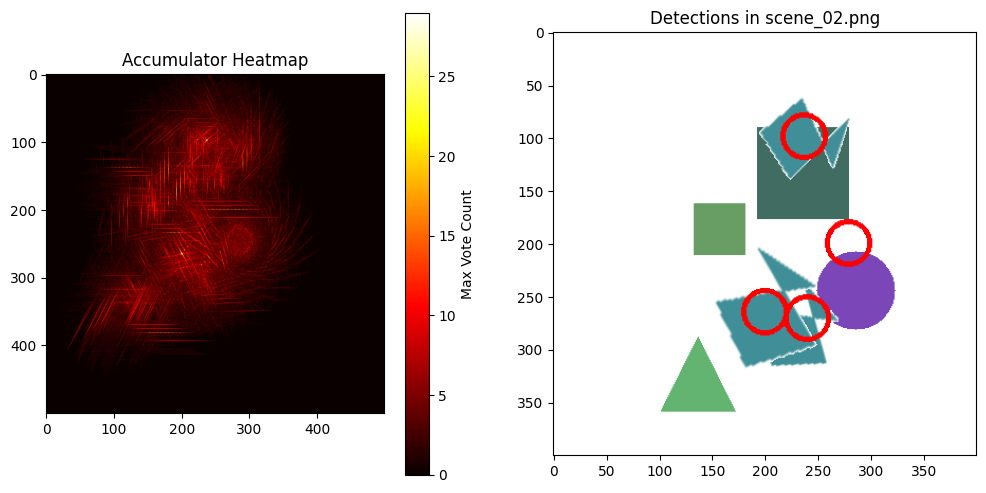

--- Detections for scene_03.png ---
Top 1: (x=101, y=128), Scale: 1x, Rot: 345 deg


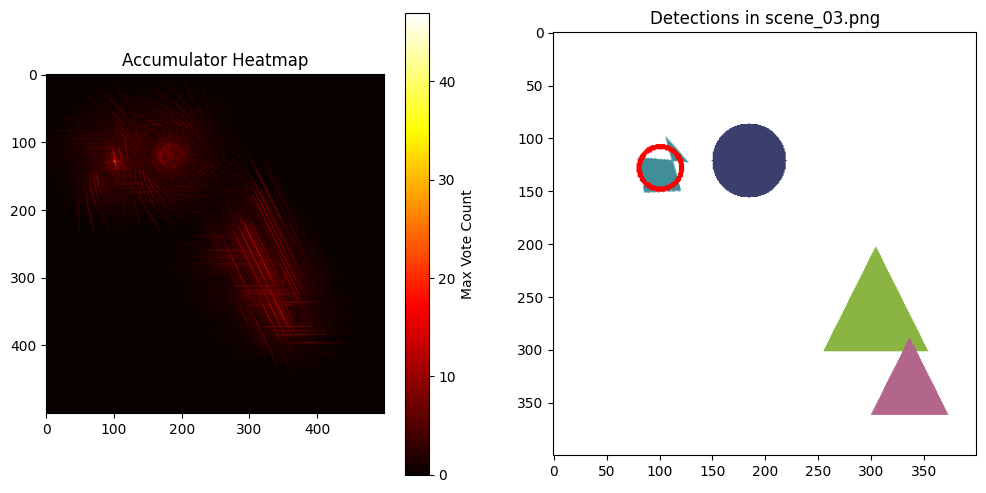

--- Detections for scene_04.png ---
Top 1: (x=200, y=304), Scale: 1x, Rot: 60 deg
Top 2: (x=262, y=162), Scale: 1.5x, Rot: 300 deg


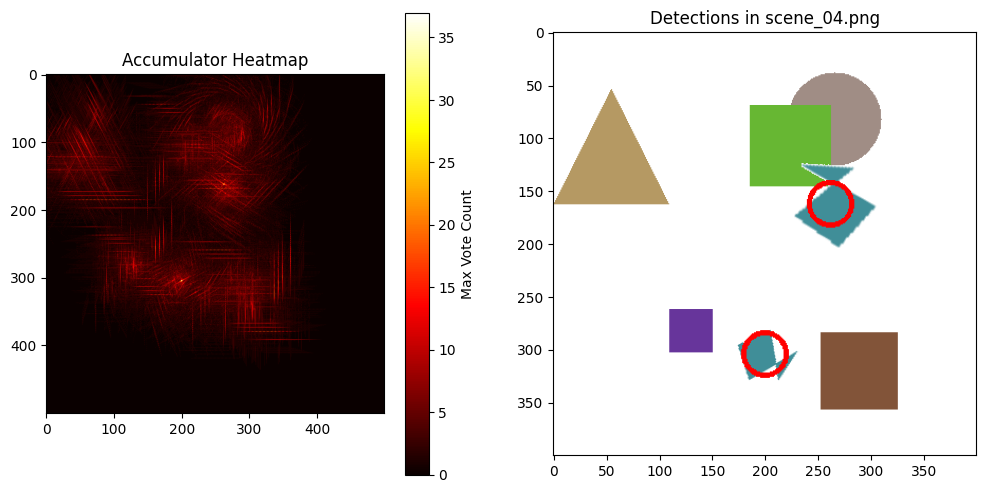

--- Detections for scene_05.png ---
Top 1: (x=178, y=227), Scale: 1.5x, Rot: 105 deg
Top 2: (x=160, y=188), Scale: 2x, Rot: 270 deg
Top 3: (x=60, y=289), Scale: 2x, Rot: 270 deg
Top 4: (x=118, y=188), Scale: 2x, Rot: 270 deg


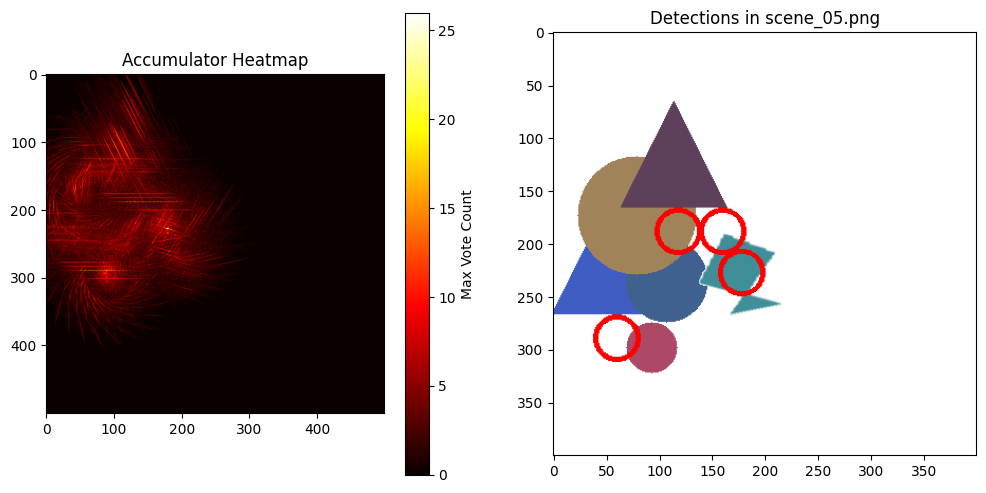

--- Detections for scene_06.png ---
Top 1: (x=64, y=117), Scale: 2x, Rot: 90 deg
Top 2: (x=156, y=180), Scale: 1x, Rot: 180 deg
Top 3: (x=132, y=233), Scale: 2x, Rot: 270 deg
Top 4: (x=199, y=205), Scale: 2x, Rot: 270 deg


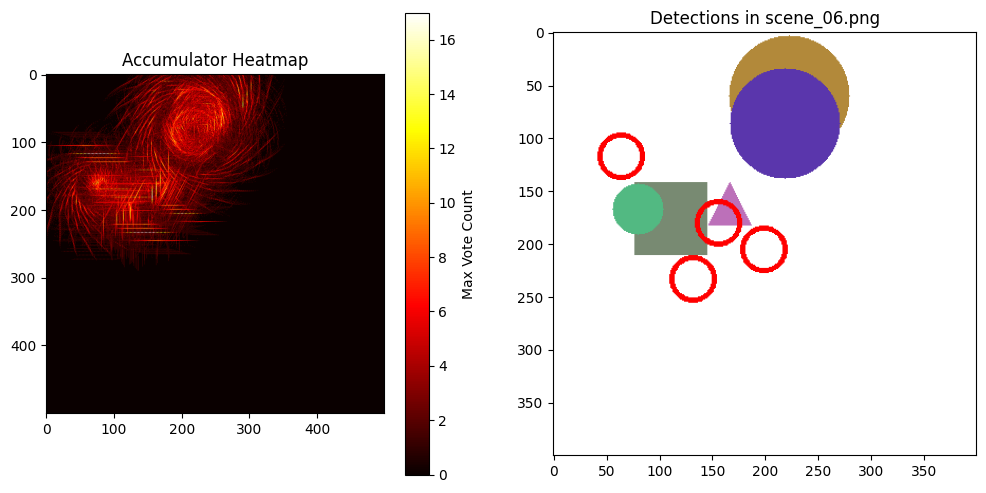

--- Detections for scene_07.png ---
Top 1: (x=221, y=203), Scale: 2x, Rot: 315 deg
Top 2: (x=305, y=139), Scale: 1.5x, Rot: 105 deg


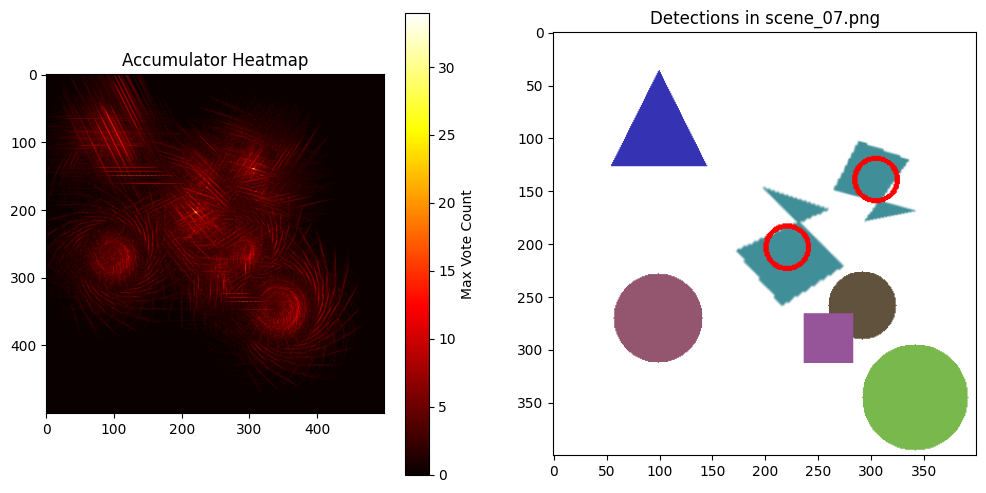

--- Detections for scene_08.png ---
Top 1: (x=80, y=170), Scale: 1x, Rot: 0 deg
Top 2: (x=111, y=159), Scale: 1.5x, Rot: 180 deg
Top 3: (x=321, y=49), Scale: 1x, Rot: 0 deg
Top 4: (x=164, y=272), Scale: 1x, Rot: 180 deg


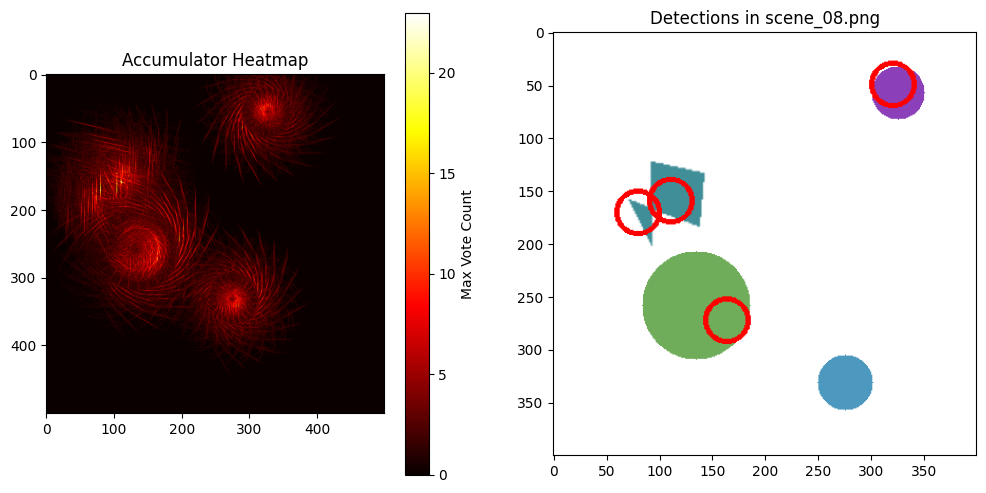

--- Detections for scene_09.png ---
Top 1: (x=93, y=141), Scale: 1x, Rot: 120 deg
Top 2: (x=83, y=165), Scale: 1x, Rot: 75 deg


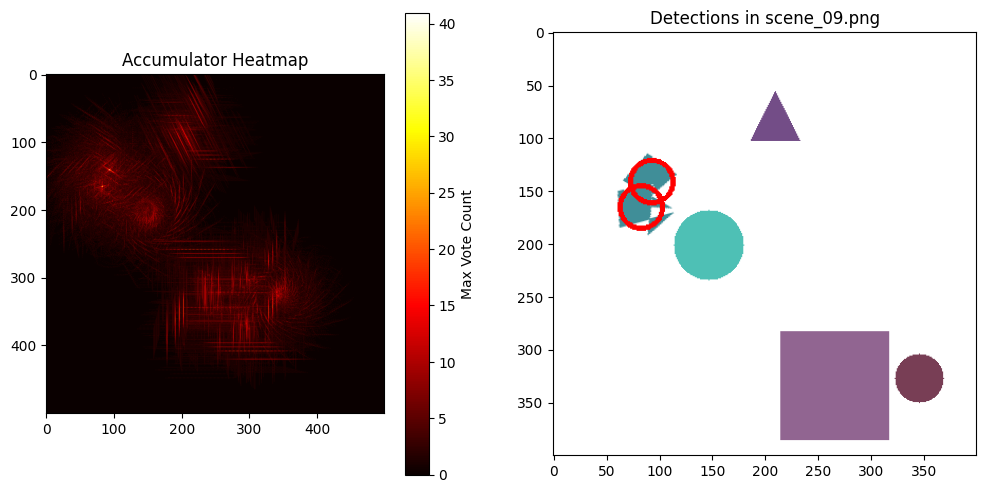

--- Detections for scene_10.png ---
Top 1: (x=174, y=252), Scale: 2x, Rot: 180 deg
Top 2: (x=131, y=269), Scale: 1.5x, Rot: 0 deg
Top 3: (x=121, y=160), Scale: 2x, Rot: 270 deg


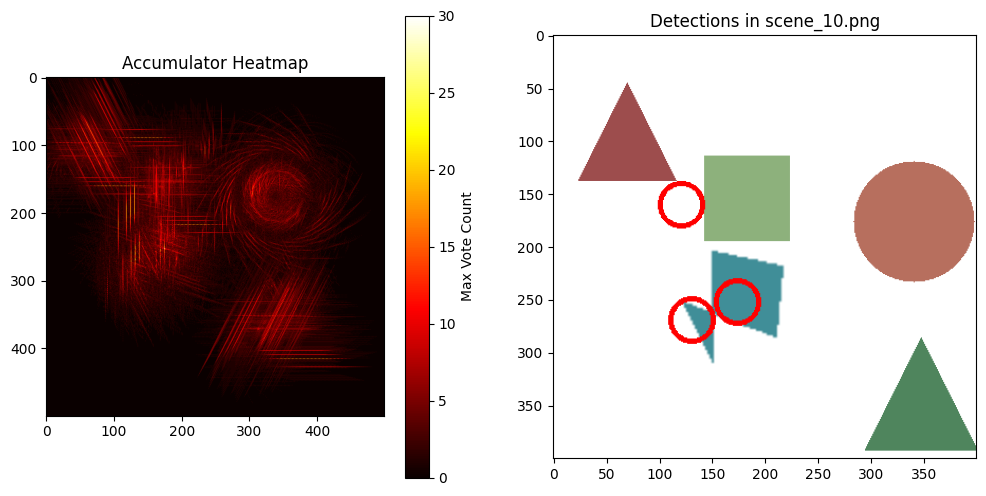

--- Detections for scene_11.png ---
Top 1: (x=302, y=146), Scale: 1.5x, Rot: 315 deg
Top 2: (x=296, y=80), Scale: 2x, Rot: 90 deg
Top 3: (x=283, y=226), Scale: 2x, Rot: 270 deg
Top 4: (x=212, y=120), Scale: 2x, Rot: 90 deg


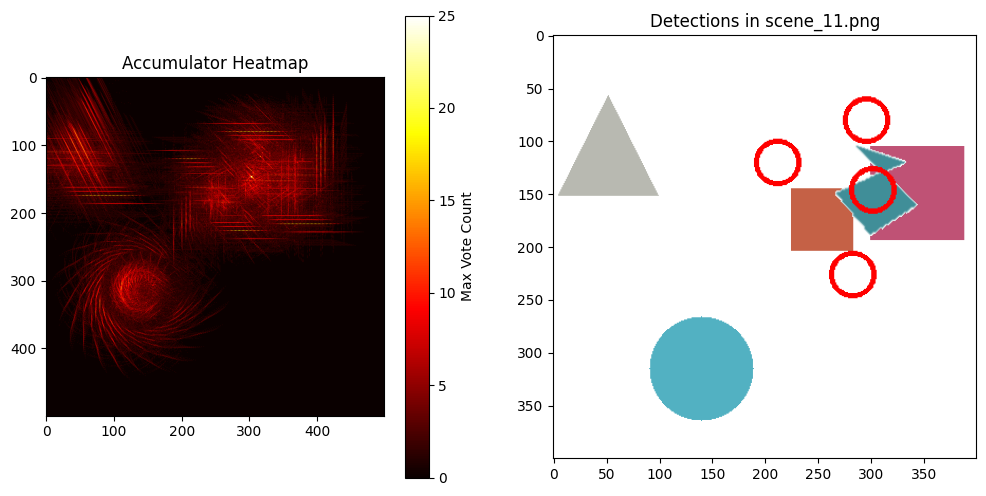

--- Detections for scene_12.png ---
Top 1: (x=263, y=187), Scale: 1x, Rot: 60 deg
Top 2: (x=155, y=182), Scale: 2x, Rot: 270 deg
Top 3: (x=281, y=239), Scale: 2x, Rot: 90 deg
Top 4: (x=259, y=335), Scale: 1x, Rot: 0 deg


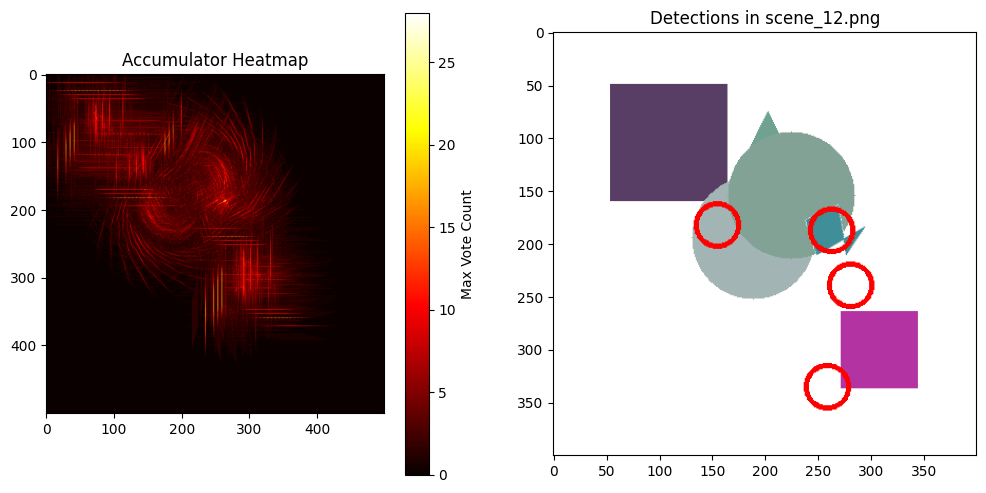

--- Detections for scene_13.png ---
Top 1: (x=122, y=326), Scale: 1x, Rot: 30 deg


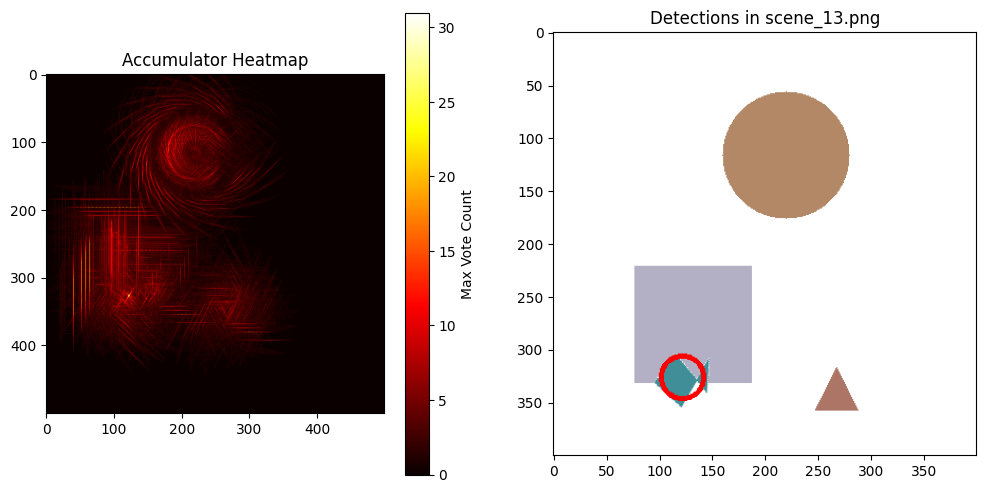

--- Detections for scene_14.png ---
Top 1: (x=122, y=251), Scale: 1.5x, Rot: 45 deg
Top 2: (x=284, y=93), Scale: 1.5x, Rot: 285 deg


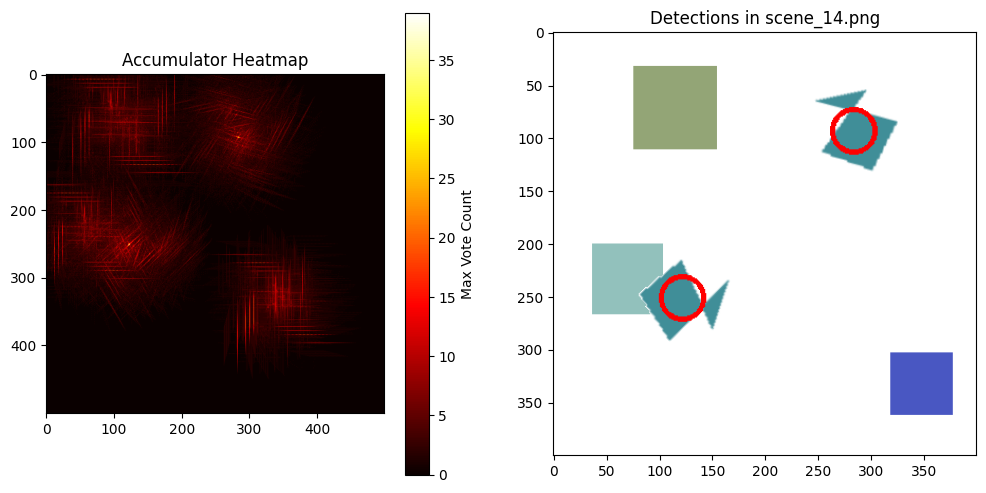

--- Detections for scene_15.png ---
Top 1: (x=222, y=219), Scale: 2x, Rot: 225 deg
Top 2: (x=145, y=250), Scale: 1x, Rot: 45 deg


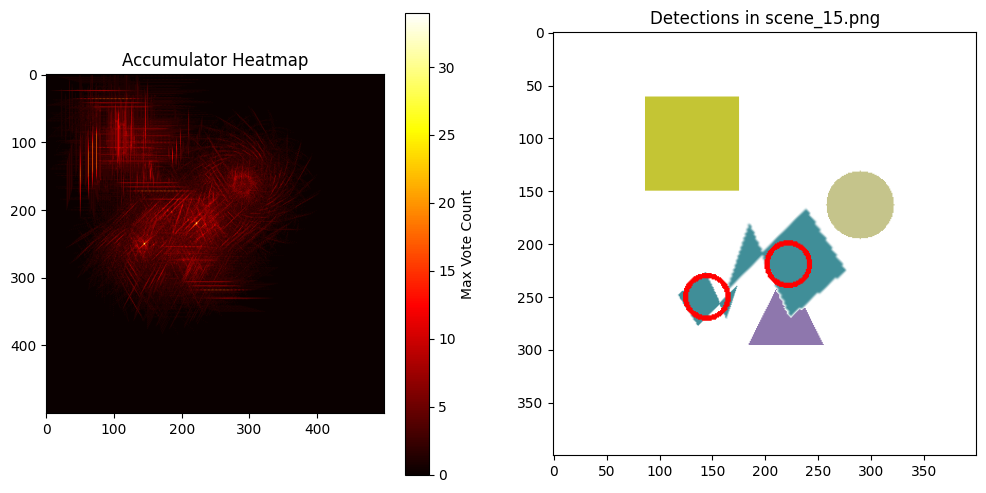

--- Detections for scene_16.png ---
Top 1: (x=68, y=125), Scale: 2x, Rot: 90 deg
Top 2: (x=15, y=144), Scale: 1x, Rot: 0 deg
Top 3: (x=150, y=148), Scale: 2x, Rot: 180 deg
Top 4: (x=30, y=235), Scale: 1x, Rot: 0 deg


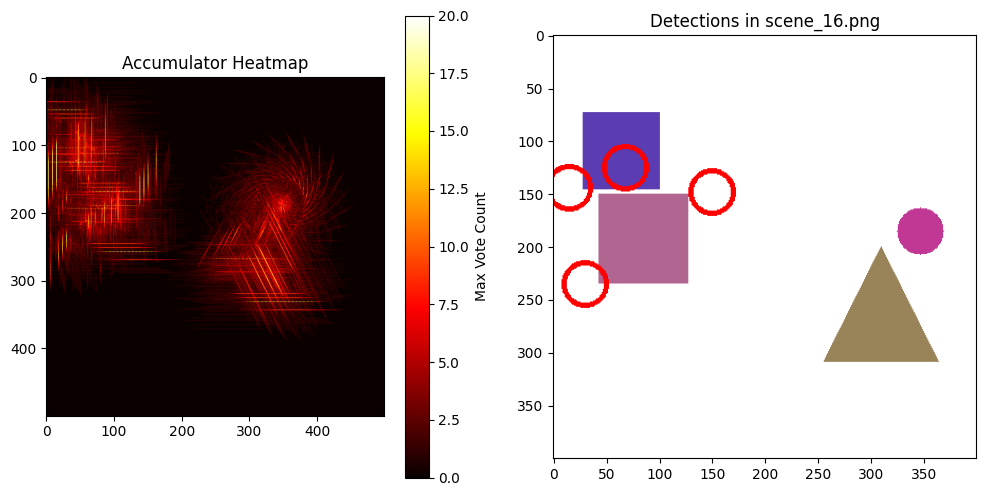

--- Detections for scene_17.png ---
Top 1: (x=275, y=162), Scale: 1.5x, Rot: 165 deg


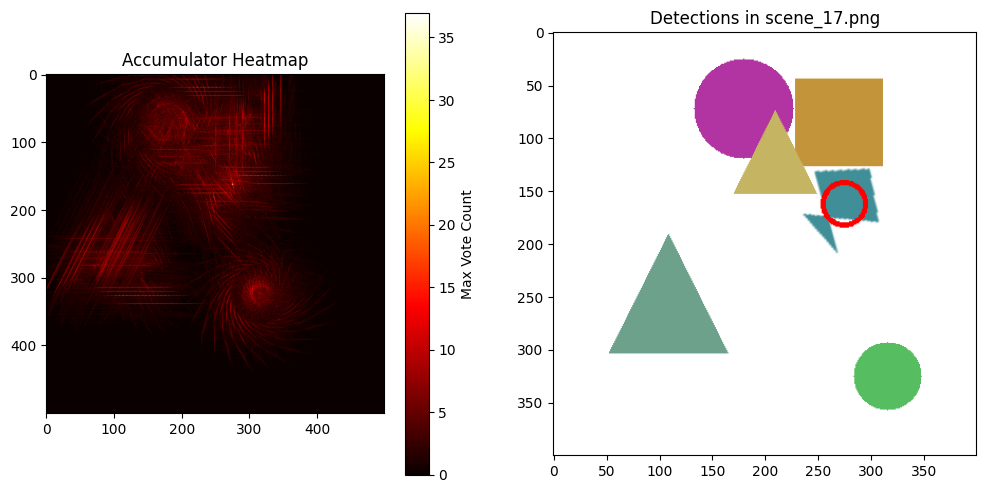

--- Detections for scene_18.png ---
Top 1: (x=212, y=261), Scale: 2x, Rot: 330 deg
Top 2: (x=293, y=91), Scale: 1x, Rot: 255 deg
Top 3: (x=149, y=92), Scale: 1.5x, Rot: 270 deg


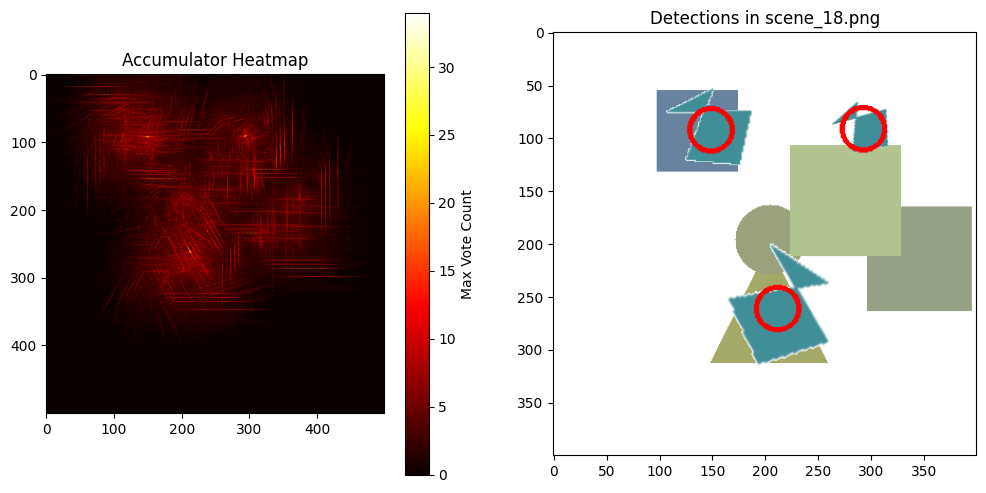

--- Detections for template.png ---
Top 1: (x=45, y=49), Scale: 1x, Rot: 0 deg


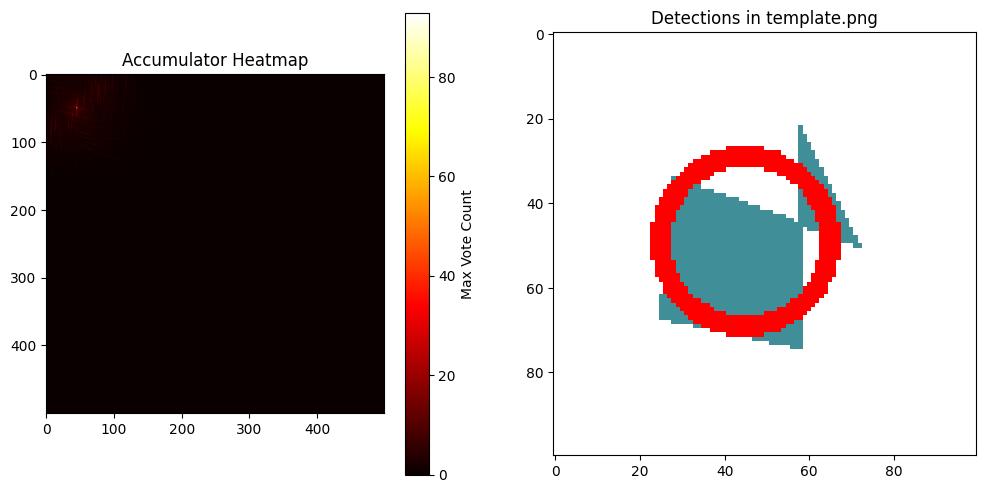

Finished displaying all images.


In [100]:
r_fish=r_table(fish_dir)
make_transform(fish_dir,r_fish)

Fish dataset gave worse results maybe because it has simliar shape twice it can detect but not with incredible accuracy.

It is still high accuracy but it fails with no fish in frame.

dataset_daisy\template.png


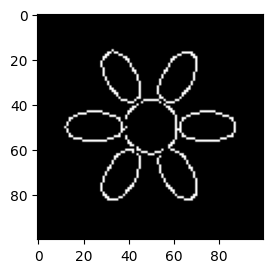

--- Detections for scene_00.png ---
Top 1: (x=265, y=224), Scale: 1x, Rot: 285 deg
Top 2: (x=209, y=271), Scale: 2x, Rot: 300 deg


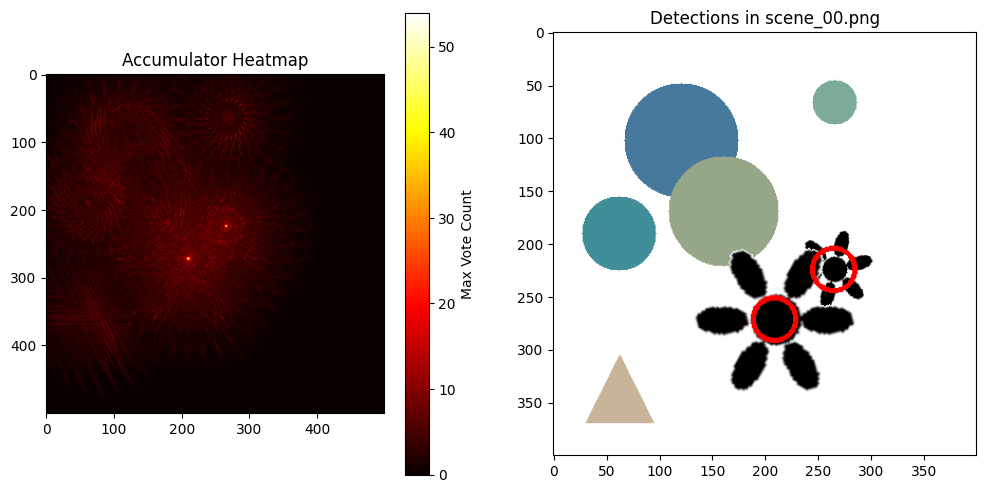

--- Detections for scene_01.png ---
Top 1: (x=100, y=244), Scale: 1x, Rot: 255 deg
Top 2: (x=165, y=197), Scale: 1x, Rot: 165 deg
Top 3: (x=284, y=197), Scale: 2x, Rot: 60 deg


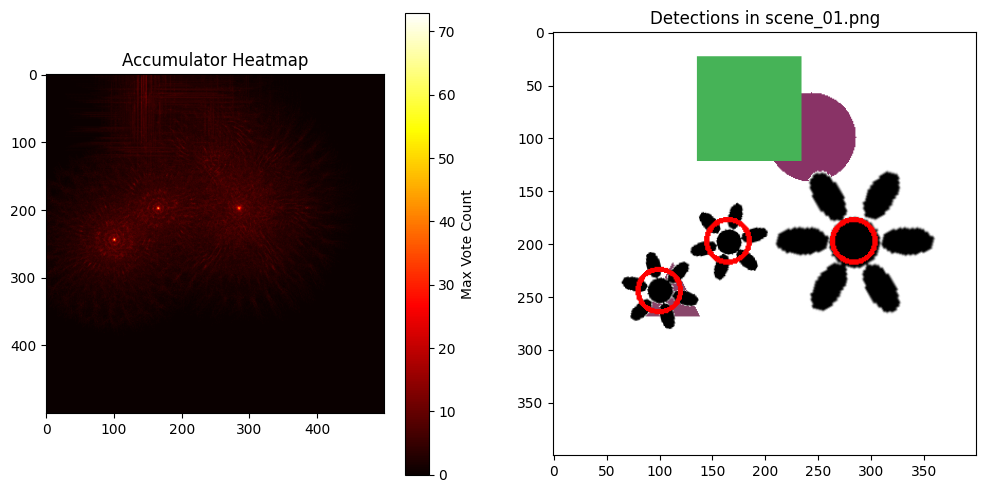

--- Detections for scene_02.png ---
Top 1: (x=307, y=142), Scale: 1.5x, Rot: 315 deg


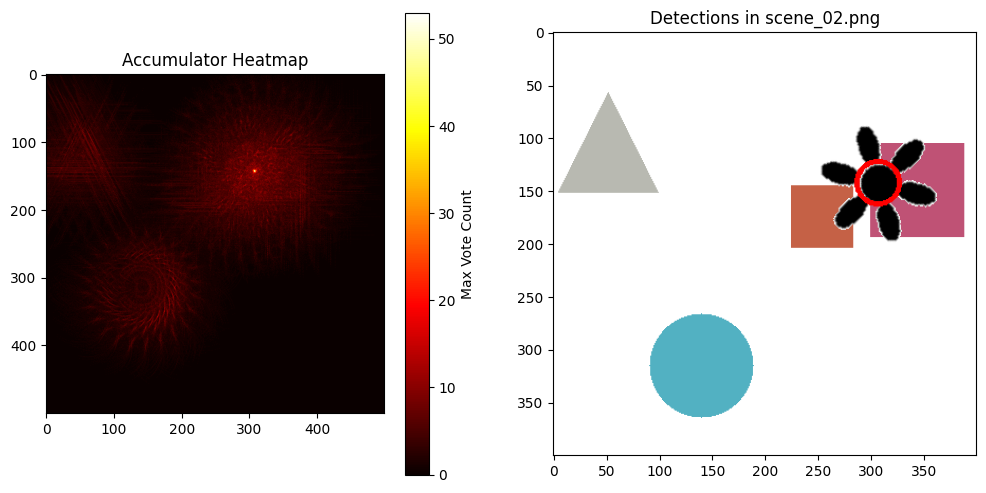

--- Detections for scene_03.png ---
Top 1: (x=105, y=127), Scale: 1x, Rot: 345 deg


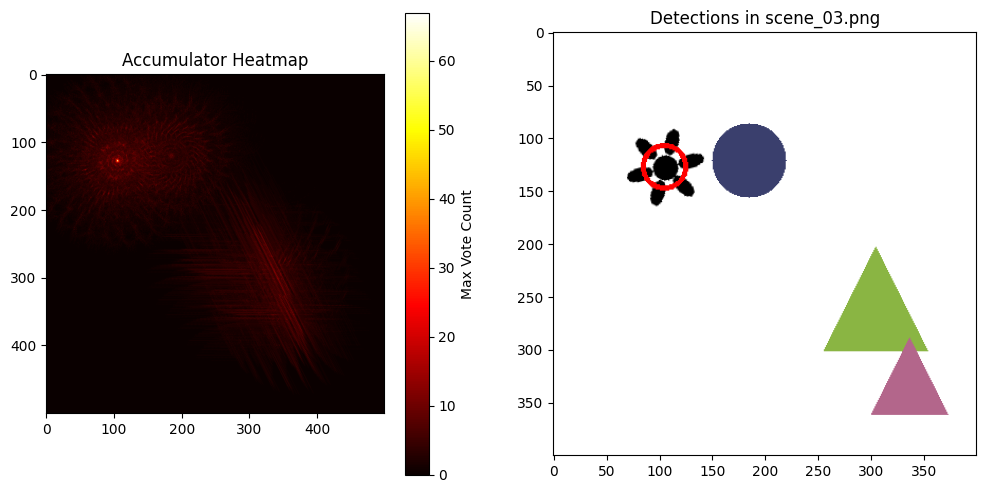

--- Detections for scene_04.png ---
Top 1: (x=202, y=308), Scale: 1x, Rot: 60 deg
Top 2: (x=265, y=157), Scale: 1.5x, Rot: 300 deg


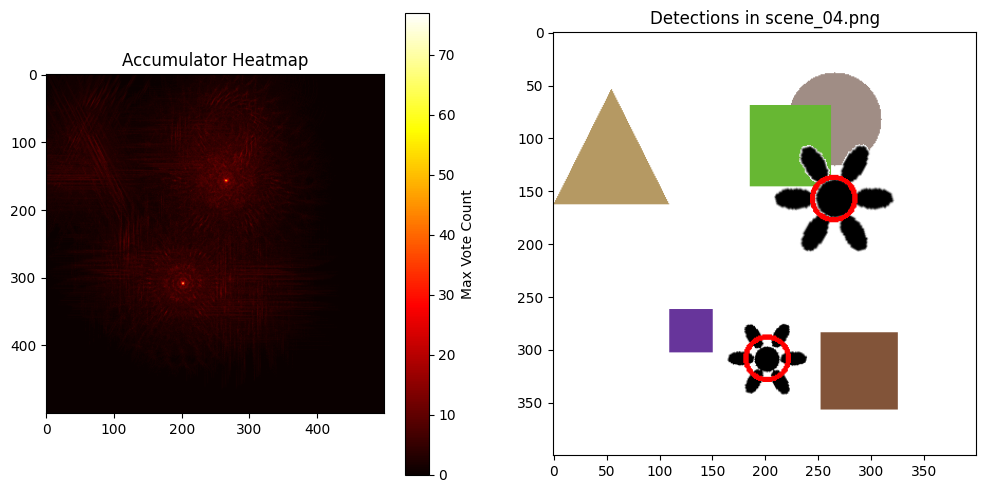

--- Detections for scene_05.png ---
Top 1: (x=177, y=233), Scale: 1.5x, Rot: 105 deg


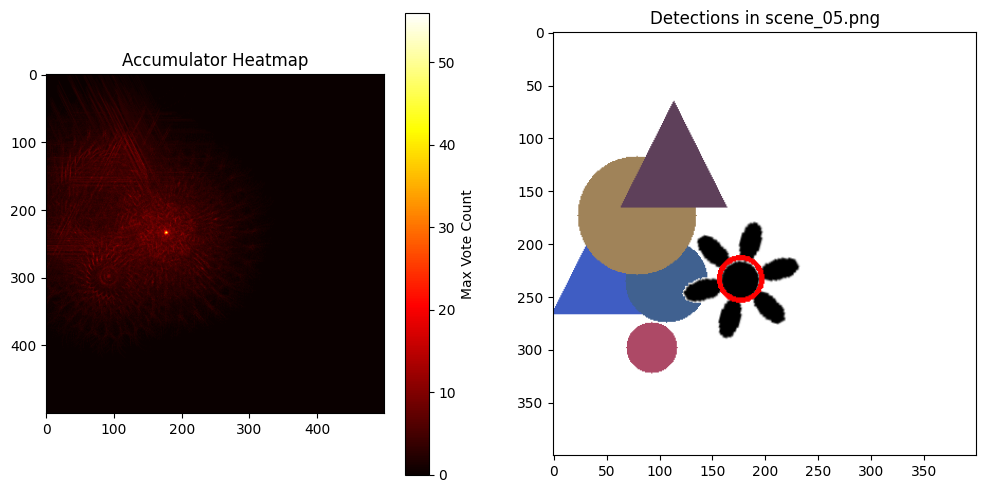

--- Detections for scene_06.png ---
Top 1: (x=62, y=143), Scale: 1x, Rot: 150 deg
Top 2: (x=215, y=0), Scale: 1.5x, Rot: 15 deg
Top 3: (x=167, y=72), Scale: 1x, Rot: 195 deg
Top 4: (x=170, y=150), Scale: 1x, Rot: 0 deg


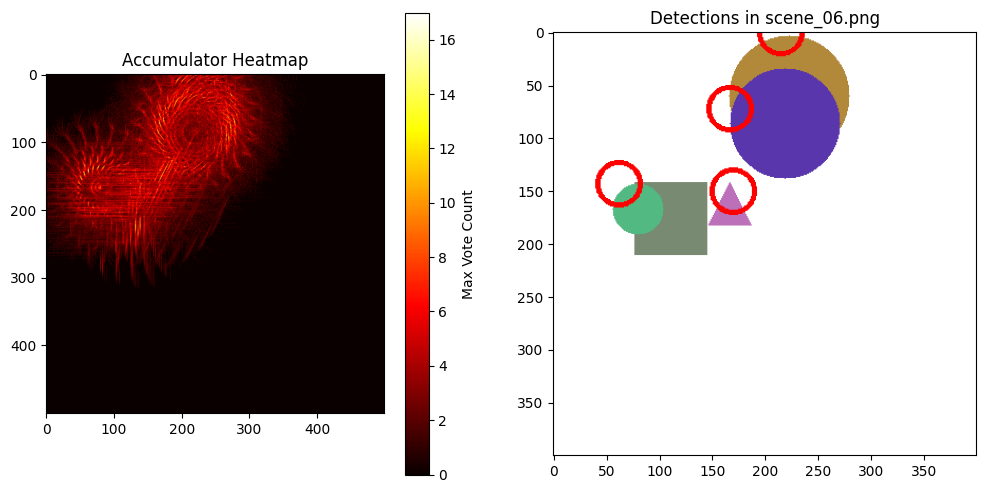

--- Detections for scene_07.png ---
Top 1: (x=303, y=146), Scale: 1.5x, Rot: 285 deg
Top 2: (x=227, y=198), Scale: 2x, Rot: 315 deg


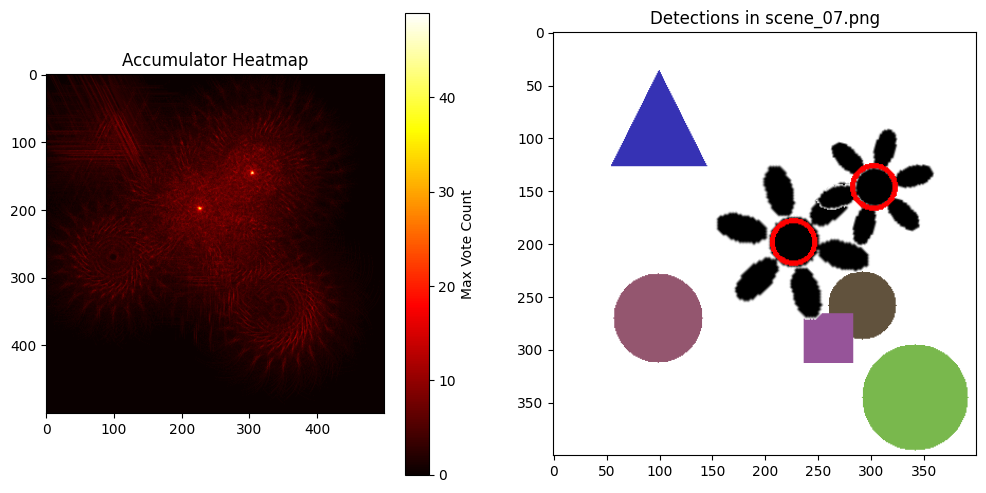

--- Detections for scene_08.png ---
Top 1: (x=105, y=159), Scale: 1.5x, Rot: 180 deg


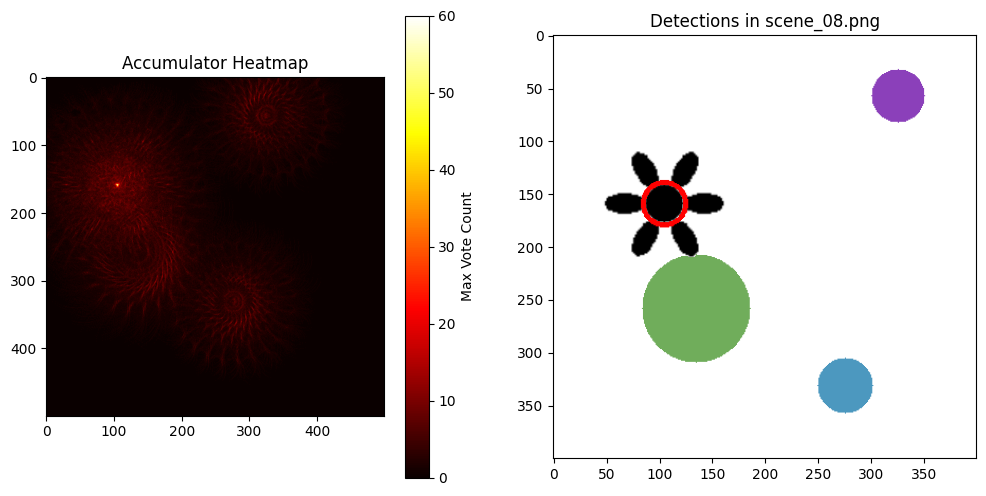

--- Detections for scene_09.png ---
Top 1: (x=84, y=169), Scale: 1x, Rot: 75 deg
Top 2: (x=91, y=144), Scale: 1x, Rot: 0 deg


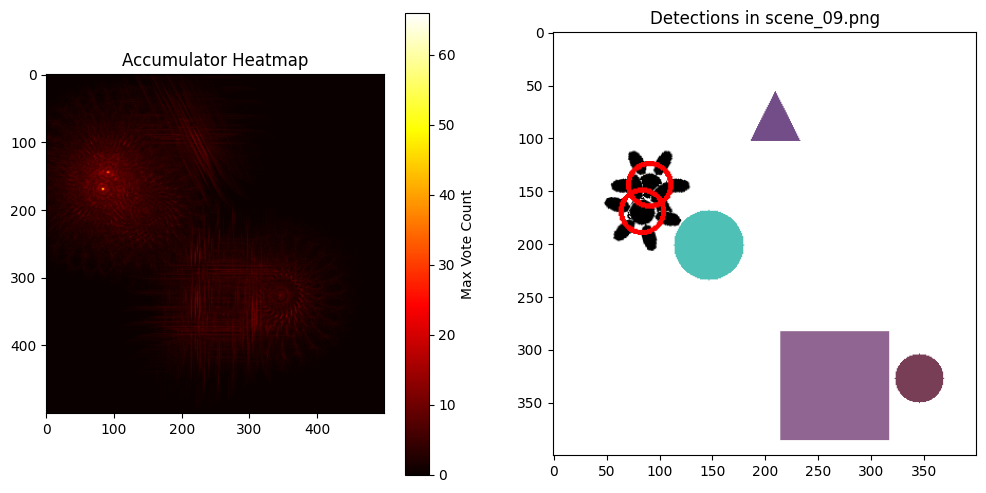

--- Detections for scene_10.png ---
Top 1: (x=168, y=252), Scale: 2x, Rot: 180 deg


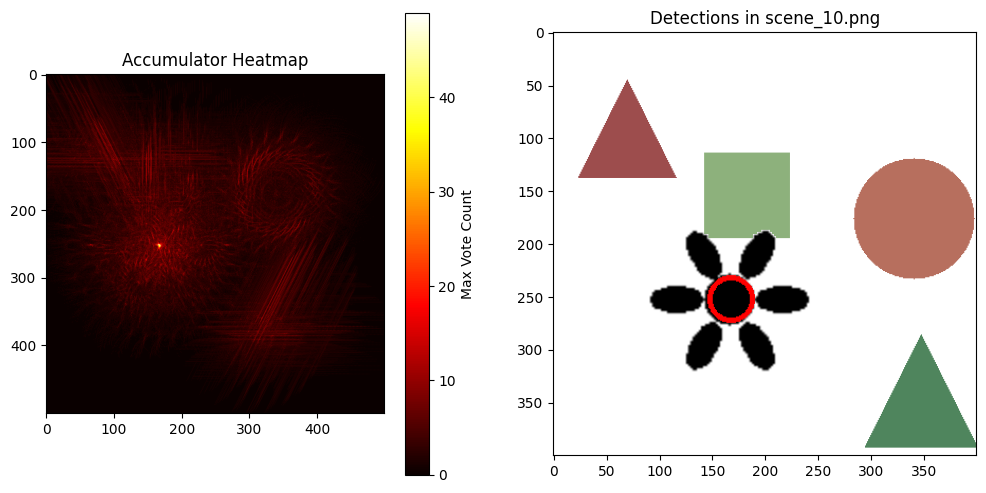

--- Detections for scene_11.png ---
Top 1: (x=292, y=87), Scale: 1x, Rot: 255 deg
Top 2: (x=149, y=87), Scale: 1.5x, Rot: 270 deg


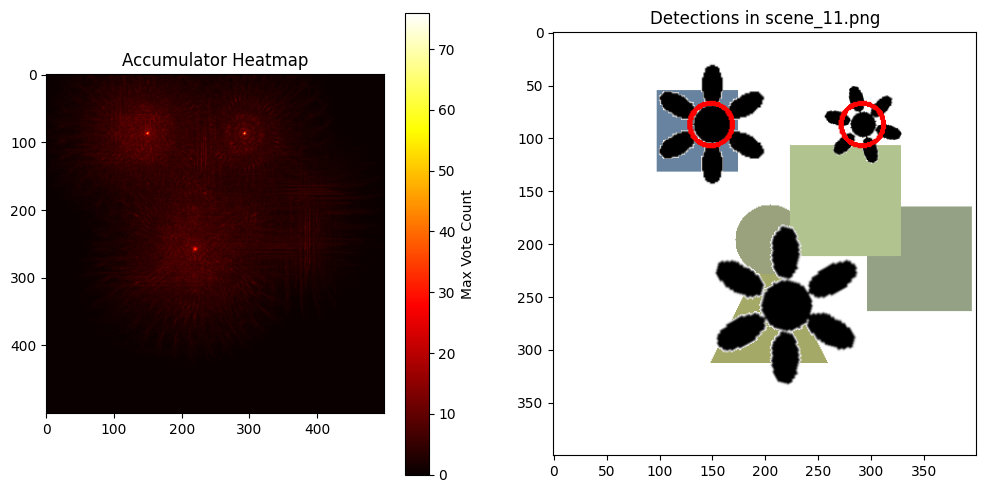

--- Detections for scene_12.png ---
Top 1: (x=266, y=190), Scale: 1x, Rot: 60 deg


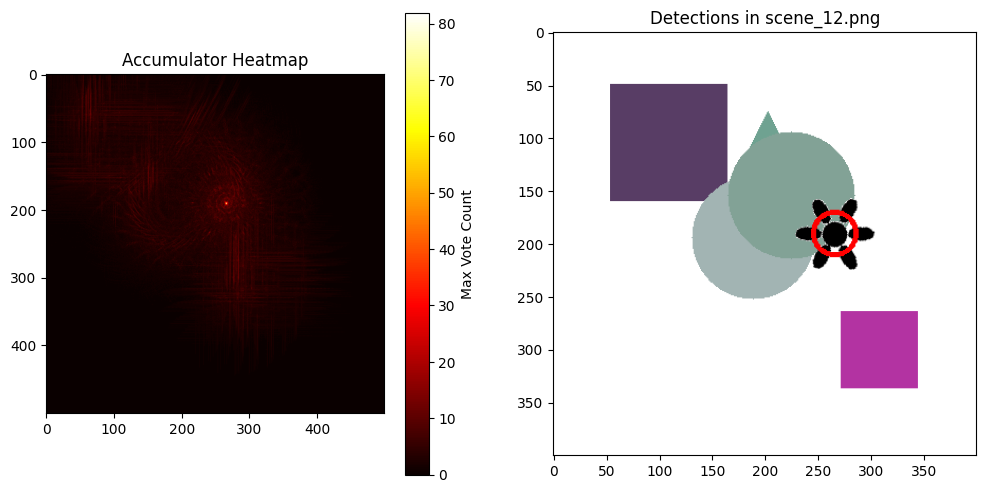

--- Detections for scene_13.png ---
Top 1: (x=125, y=328), Scale: 1x, Rot: 270 deg


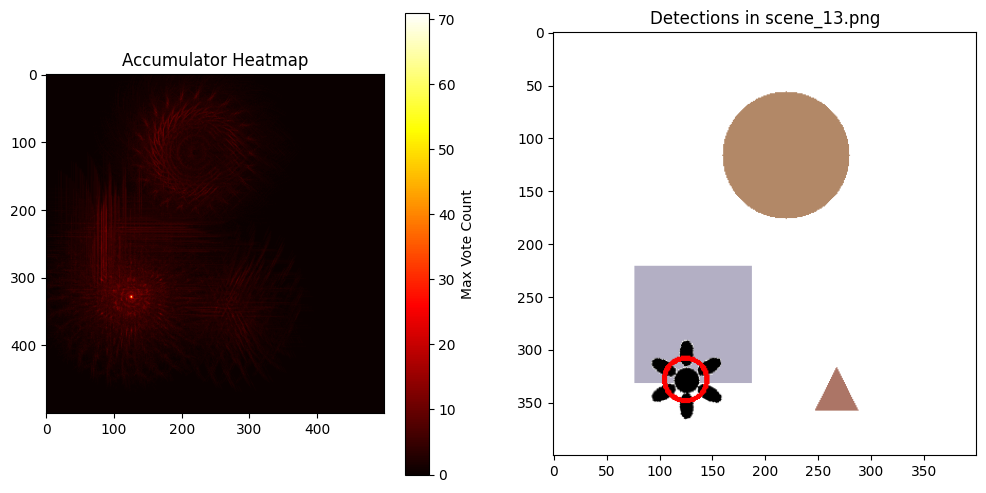

--- Detections for scene_14.png ---
Top 1: (x=127, y=255), Scale: 1.5x, Rot: 45 deg
Top 2: (x=286, y=87), Scale: 1.5x, Rot: 165 deg


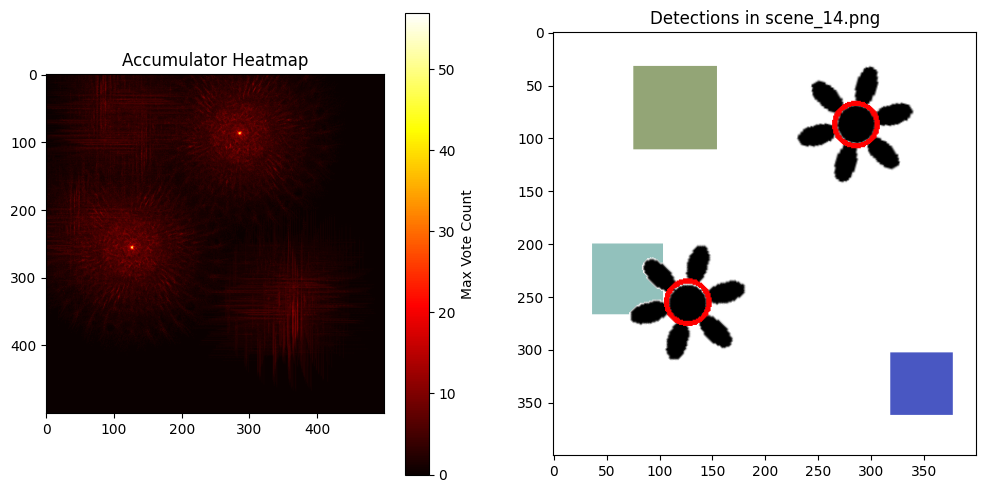

--- Detections for scene_15.png ---
Top 1: (x=147, y=253), Scale: 1x, Rot: 45 deg
Top 2: (x=215, y=213), Scale: 2x, Rot: 225 deg


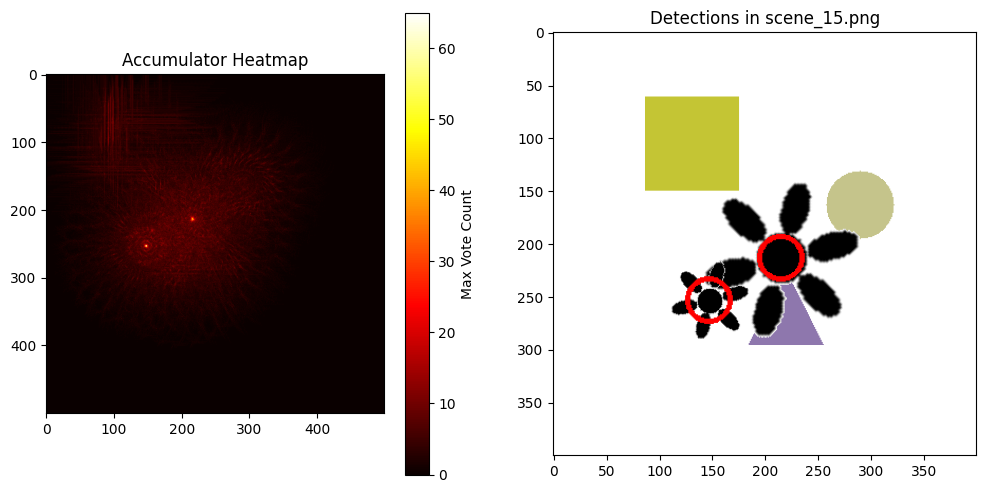

--- Detections for scene_17.png ---
Top 1: (x=269, y=164), Scale: 1.5x, Rot: 165 deg


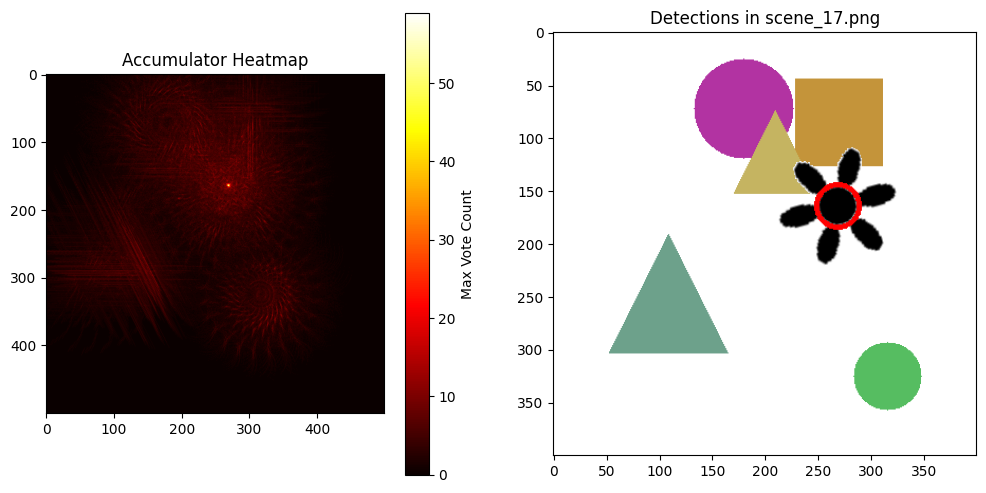

--- Detections for template.png ---
Top 1: (x=49, y=49), Scale: 1x, Rot: 0 deg


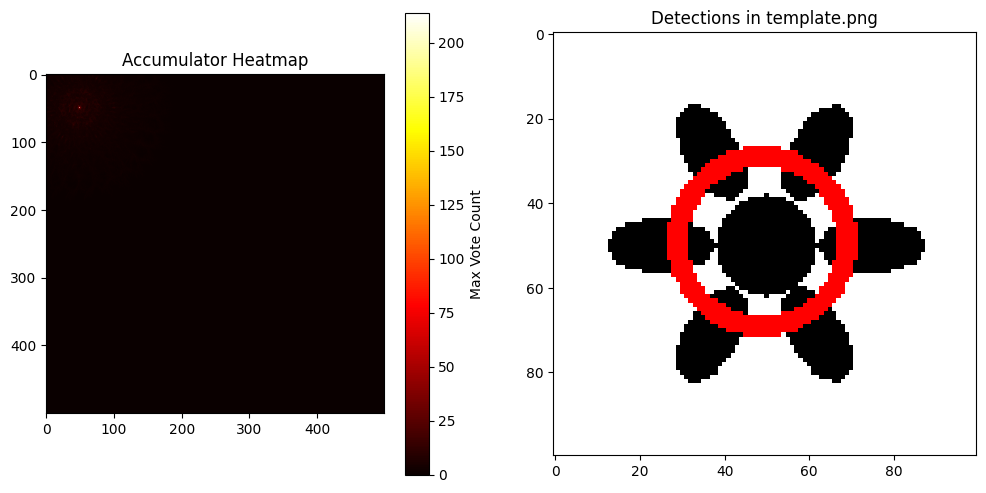

Finished displaying all images.


In [101]:

r_flower=r_table(flower_dir)
make_transform(flower_dir,r_flower)

Flower dataset gave very good results with only one not found flower. It still is not working with no template in the image and find random points with high votes. Flower shape has a distict shape ad more adges so it is easier to detect.

It always fails with no tempate on the image since the most votes is some random place and has some same values. It also failed at scene 11 daist maybe because it is in a big shape and some edges arent properly detecetd.

I learnd how hough transform works with finding a pattern in a image and some mathematical formulas behind it. It works good but not very accurate compared to modern techniques. By checking hyperparameters it may have better results and the no pattern cases it needs a solituon.